In [1]:
import numpy as np
import os
import tensorflow as tf
import keras
import setup_cifar
import denoise_model
from matplotlib import pyplot as plt
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod, BasicIterativeMethod
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8578839935737755239
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7767347249903548728
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6955633188988875469
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4247097928377860348
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:2"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17027140282502243451
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:3"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5936328262230464497
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: 

In [3]:
tf.compat.v1.disable_eager_execution()

### Data preprocessing (CIFAR-10)

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

### CIFAR-10 model loading (ResNet, VGG16)

In [5]:
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
input_shape = (32, 32, 3)

model_resnet = setup_cifar.resnet_v2(input_shape, 20)
model_vgg16 = setup_cifar.model_vgg16(input_shape)
model_resnet.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])
model_vgg16.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])

model_resnet_path = "model/model_resnet.h5"
model_vgg16_path = "model/model_vgg16.h5"
model_resnet.load_weights(model_resnet_path)
model_vgg16.load_weights(model_vgg16_path)

#### ResNet accuracy

In [6]:
loss_test, accuracy_test = model_resnet.evaluate(x_test, y_test)
print('Accuracy on total test data: {:4.2f}%'.format(accuracy_test * 100))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Accuracy on total test data: 87.26%


#### VGG16 accuracy

In [7]:
loss_test, accuracy_test = model_vgg16.evaluate(x_test, y_test)
print('Accuracy on total test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on total test data: 89.18%


In [8]:
x_test_atk = x_test[0:100]
y_test_atk = y_test[0:100]

#### ResNet test accuracy

In [9]:
loss_test, accuracy_test = model_resnet.evaluate(x_test_atk, y_test_atk)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 92.00%


#### VGG16 test accuracy

In [10]:
loss_test, accuracy_test = model_vgg16.evaluate(x_test_atk, y_test_atk)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 91.00%


In [11]:
def plt_show(img):
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Original test image


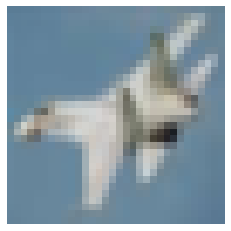

In [12]:
test_index = 10
print('Original test image')
plt_show(x_test_atk[test_index])

In [13]:
classifier_resnet = KerasClassifier(model=model_resnet, use_logits=True, clip_values=(0, 1))
classifier_vgg16 = KerasClassifier(model=model_vgg16, use_logits=True, clip_values=(0, 1))

### Attack test on FGSM (ResNet)

In [14]:
attack_fgsm_resnet = FastGradientMethod(estimator=classifier_resnet, eps=0.03)
x_test_adv_fgsm_resnet = attack_fgsm_resnet.generate(x_test_atk)

In [15]:
loss_test, accuracy_test = model_resnet.evaluate(x_test_adv_fgsm_resnet, y_test_atk)
perturbation = np.mean(np.abs((x_test_adv_fgsm_resnet - x_test_atk)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 8.00%
Average perturbation: 0.03


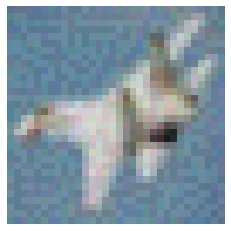

In [16]:
plt_show(x_test_adv_fgsm_resnet[test_index])

### Attack test on FGSM (VGG16)

In [17]:
attack_fgsm_vgg16 = FastGradientMethod(estimator=classifier_vgg16, eps=0.03)
x_test_adv_fgsm_vgg16 = attack_fgsm_vgg16.generate(x_test_atk)

In [18]:
loss_test, accuracy_test = model_vgg16.evaluate(x_test_adv_fgsm_vgg16, y_test_atk)
perturbation = np.mean(np.abs((x_test_adv_fgsm_vgg16 - x_test_atk)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 46.00%
Average perturbation: 0.03


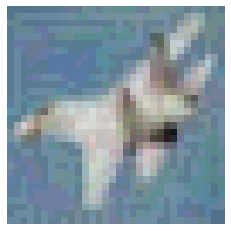

In [19]:
plt_show(x_test_adv_fgsm_vgg16[test_index])

### Attack test on C&W Method (ResNet)

In [20]:
attack_cw_resnet = CarliniLInfMethod(classifier=classifier_resnet, eps=0.03, max_iter=100, learning_rate=0.01)
x_test_adv_cw_resnet = attack_cw_resnet.generate(x_test_atk)

C&W L_inf: 100%|██████████| 1/1 [00:25<00:00, 25.49s/it]


In [21]:
loss_test, accuracy_test = model_resnet.evaluate(x_test_adv_cw_resnet, y_test_atk)
perturbation = np.mean(np.abs((x_test_adv_cw_resnet - x_test_atk)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 6.00%
Average perturbation: 0.00


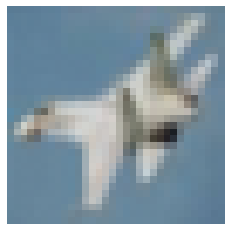

In [22]:
plt_show(x_test_adv_cw_resnet[test_index])

### Attack test on C&W Method (VGG16)

In [23]:
attack_cw_vgg16 = CarliniLInfMethod(classifier=classifier_vgg16, eps=0.03, max_iter=100, learning_rate=0.01)
x_test_adv_cw_vgg16 = attack_cw_vgg16.generate(x_test_atk)

C&W L_inf: 100%|██████████| 1/1 [00:10<00:00, 10.29s/it]


In [24]:
loss_test, accuracy_test = model_vgg16.evaluate(x_test_adv_cw_vgg16, y_test_atk)
perturbation = np.mean(np.abs((x_test_adv_cw_vgg16 - x_test_atk)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 4.00%
Average perturbation: 0.00


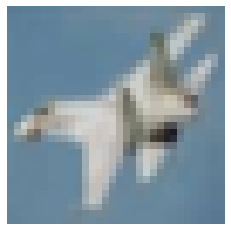

In [25]:
plt_show(x_test_adv_cw_vgg16[test_index])

### Attack test on PGD (BIM) Method (ResNet)

In [26]:
attack_pgd_resnet = BasicIterativeMethod(estimator=classifier_resnet, eps=0.03, eps_step=0.01, max_iter=100)
x_test_adv_pgd_resnet = attack_pgd_resnet.generate(x_test_atk)

In [27]:
loss_test, accuracy_test = model_resnet.evaluate(x_test_adv_pgd_resnet, y_test_atk)
perturbation = np.mean(np.abs((x_test_adv_pgd_resnet - x_test_atk)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 6.00%
Average perturbation: 0.02


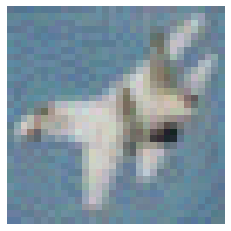

In [28]:
plt_show(x_test_adv_pgd_resnet[test_index])

### Attack test on PGD (BIM) Method (VGG16)

In [29]:
attack_pgd_vgg16 = BasicIterativeMethod(estimator=classifier_vgg16, eps=0.03, eps_step=0.01, max_iter=100)
x_test_adv_pgd_vgg16 = attack_pgd_vgg16.generate(x_test_atk)

In [30]:
loss_test, accuracy_test = model_vgg16.evaluate(x_test_adv_pgd_vgg16, y_test_atk)
perturbation = np.mean(np.abs((x_test_adv_pgd_vgg16 - x_test_atk)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 34.00%
Average perturbation: 0.02


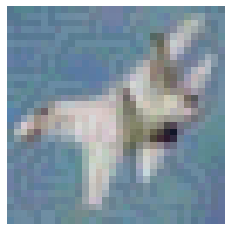

In [31]:
plt_show(x_test_adv_pgd_vgg16[test_index])

### Transferability test on PGD between ResNet and VGG16

In [32]:
loss_test, accuracy_test = model_resnet.evaluate(x_test_adv_pgd_vgg16, y_test_atk)
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on adversarial test data: 64.00%


In [33]:
loss_test, accuracy_test = model_vgg16.evaluate(x_test_adv_pgd_resnet, y_test_atk)
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on adversarial test data: 69.00%


### Denoiser test (before training validation model [just adding denoiser])

In [34]:
dae_resnet_path = 'model/DAE_resnet.h5'
dae_vgg_path = 'model/DAE_vgg.h5'
dm_gaussian_blur_path = 'model/dm_gaussian_blur.h5'
dm_median_blur_path = 'model/dm_median_blur.h5'
dm_dae_resnet_model_resnet_path = 'model/dm_dae_resnet_model_resnet.h5'
dm_dae_vgg_model_resnet_path = 'model/dm_dae_vgg_model_resnet.h5'
dm_dae_resnet_model_vgg_path = 'model/dm_dae_resnet_model_vgg.h5'
dm_dae_vgg_model_vgg_path = 'model/dm_dae_vgg_model_vgg.h5'

dm_gaussian_blur = denoise_model.DM_GAUSSIAN_BLUR()
dm_median_blur = denoise_model.DM_MEDIAN_BLUR()
dm_nl_means = denoise_model.DM_NL_MEANS()
dm_dae_resnet_model_resnet = denoise_model.DM_DAE_RESNET()
dm_dae_vgg_model_resnet = denoise_model.DM_DAE_VGG()
dm_dae_resnet_model_vgg = denoise_model.DM_DAE_RESNET(model="vgg16")
dm_dae_vgg_model_vgg = denoise_model.DM_DAE_VGG(model="vgg16")

In [35]:
dm_dae_resnet_model_resnet.denoiser.compile(loss='mse', optimizer='adam')
dm_dae_vgg_model_resnet.denoiser.compile(loss='mse', optimizer='adam')
dm_dae_resnet_model_vgg.denoiser.compile(loss='mse', optimizer='adam')
dm_dae_vgg_model_vgg.denoiser.compile(loss='mse', optimizer='adam')

dm_gaussian_blur.model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])
dm_median_blur.model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])
dm_nl_means.model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])
dm_dae_resnet_model_resnet.model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])
dm_dae_vgg_model_resnet.model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])
dm_dae_resnet_model_vgg.model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])
dm_dae_vgg_model_vgg.model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])

dm_gaussian_blur.denoise_model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])
dm_median_blur.denoise_model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])
dm_nl_means.denoise_model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])
dm_dae_resnet_model_resnet.denoise_model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])
dm_dae_vgg_model_resnet.denoise_model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])
dm_dae_resnet_model_vgg.denoise_model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])
dm_dae_vgg_model_vgg.denoise_model.compile(loss=loss_object, optimizer='adam', metrics=['accuracy'])

dm_dae_resnet_model_resnet.denoiser.load_weights(dae_resnet_path)
dm_dae_vgg_model_resnet.denoiser.load_weights(dae_vgg_path)
dm_dae_resnet_model_vgg.denoiser.load_weights(dae_resnet_path)
dm_dae_vgg_model_vgg.denoiser.load_weights(dae_vgg_path)

dm_gaussian_blur.model.load_weights(model_resnet_path)
dm_median_blur.model.load_weights(model_resnet_path)
dm_nl_means.model.load_weights(model_resnet_path)
dm_dae_resnet_model_resnet.model.load_weights(model_resnet_path)
dm_dae_vgg_model_resnet.model.load_weights(model_resnet_path)
dm_dae_resnet_model_vgg.model.load_weights(model_vgg16_path)
dm_dae_vgg_model_vgg.model.load_weights(model_vgg16_path)

#### Original image accuracy

In [36]:
loss_test, accuracy_test = dm_gaussian_blur.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [Gaussian Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Gaussian Blur] on test data: 64.00%


In [37]:
loss_test, accuracy_test = dm_median_blur.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [Median Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Median Blur] on test data: 81.00%


In [38]:
loss_test, accuracy_test = dm_nl_means.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [Non-Local Means] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Non-Local Means] on test data: 73.00%


In [39]:
loss_test, accuracy_test = dm_dae_resnet_model_resnet.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [DAE_ResNet & Model_ResNet] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_ResNet & Model_ResNet] on test data: 71.00%


In [40]:
loss_test, accuracy_test = dm_dae_vgg_model_resnet.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [DAE_VGG & Model_ResNet] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_VGG & Model_ResNet] on test data: 66.00%


In [41]:
loss_test, accuracy_test = dm_dae_resnet_model_vgg.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [DAE_ResNet & Model_VGG] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_ResNet & Model_VGG] on test data: 76.00%


In [42]:
loss_test, accuracy_test = dm_dae_vgg_model_vgg.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [DAE_VGG & Model_VGG] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_VGG & Model_VGG] on test data: 79.00%


#### FGSM accuracy

In [43]:
loss_test, accuracy_test = dm_gaussian_blur.denoise_model.evaluate(x_test_adv_fgsm_resnet, y_test_atk)
print('Accuracy [Gaussian Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Gaussian Blur] on test data: 37.00%


In [44]:
loss_test, accuracy_test = dm_median_blur.denoise_model.evaluate(x_test_adv_fgsm_resnet, y_test_atk)
print('Accuracy [Median Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Median Blur] on test data: 43.00%


In [45]:
loss_test, accuracy_test = dm_nl_means.denoise_model.evaluate(x_test_adv_fgsm_resnet, y_test_atk)
print('Accuracy [Non-Local Means] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Non-Local Means] on test data: 32.00%


In [46]:
loss_test, accuracy_test = dm_dae_resnet_model_resnet.denoise_model.evaluate(x_test_adv_fgsm_resnet, y_test_atk)
print('Accuracy [DAE_ResNet & Model_ResNet] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_ResNet & Model_ResNet] on test data: 56.00%


In [47]:
loss_test, accuracy_test = dm_dae_vgg_model_resnet.denoise_model.evaluate(x_test_adv_fgsm_resnet, y_test_atk)
print('Accuracy [DAE_VGG & Model_ResNet] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_VGG & Model_ResNet] on test data: 57.00%


#### C&W accuracy

In [48]:
loss_test, accuracy_test = dm_gaussian_blur.denoise_model.evaluate(x_test_adv_cw_resnet, y_test_atk)
print('Accuracy [Gaussian Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Gaussian Blur] on test data: 60.00%


In [49]:
loss_test, accuracy_test = dm_median_blur.denoise_model.evaluate(x_test_adv_cw_resnet, y_test_atk)
print('Accuracy [Median Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Median Blur] on test data: 74.00%


In [50]:
loss_test, accuracy_test = dm_nl_means.denoise_model.evaluate(x_test_adv_cw_resnet, y_test_atk)
print('Accuracy [Non-Local Means] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Non-Local Means] on test data: 70.00%


In [51]:
loss_test, accuracy_test = dm_dae_resnet_model_resnet.denoise_model.evaluate(x_test_adv_cw_resnet, y_test_atk)
print('Accuracy [DAE_ResNet & Model_ResNet] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_ResNet & Model_ResNet] on test data: 67.00%


In [52]:
loss_test, accuracy_test = dm_dae_vgg_model_resnet.denoise_model.evaluate(x_test_adv_cw_resnet, y_test_atk)
print('Accuracy [DAE_VGG & Model_ResNet] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_VGG & Model_ResNet] on test data: 65.00%


#### PGD accuracy

In [53]:
loss_test, accuracy_test = dm_gaussian_blur.denoise_model.evaluate(x_test_adv_pgd_resnet, y_test_atk)
print('Accuracy [Gaussian Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Gaussian Blur] on test data: 35.00%


In [54]:
loss_test, accuracy_test = dm_median_blur.denoise_model.evaluate(x_test_adv_pgd_resnet, y_test_atk)
print('Accuracy [Median Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Median Blur] on test data: 43.00%


In [55]:
loss_test, accuracy_test = dm_nl_means.denoise_model.evaluate(x_test_adv_pgd_resnet, y_test_atk)
print('Accuracy [Non-Local Means] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Non-Local Means] on test data: 31.00%


In [56]:
loss_test, accuracy_test = dm_dae_resnet_model_resnet.denoise_model.evaluate(x_test_adv_pgd_resnet, y_test_atk)
print('Accuracy [DAE_ResNet & Model_ResNet] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_ResNet & Model_ResNet] on test data: 57.00%


In [57]:
loss_test, accuracy_test = dm_dae_vgg_model_resnet.denoise_model.evaluate(x_test_adv_pgd_resnet, y_test_atk)
print('Accuracy [DAE_VGG & Model_ResNet] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_VGG & Model_ResNet] on test data: 55.00%


### Denoiser test after training validation model

In [58]:
dm_gaussian_blur.denoise_model.load_weights(dm_gaussian_blur_path)
dm_median_blur.denoise_model.load_weights(dm_median_blur_path)
dm_dae_resnet_model_resnet.denoise_model.load_weights(dm_dae_resnet_model_resnet_path)
dm_dae_vgg_model_resnet.denoise_model.load_weights(dm_dae_vgg_model_resnet_path)
dm_dae_resnet_model_vgg.denoise_model.load_weights(dm_dae_resnet_model_vgg_path)
dm_dae_vgg_model_vgg.denoise_model.load_weights(dm_dae_vgg_model_vgg_path)

#### Original image accuracy

In [59]:
loss_test, accuracy_test = dm_gaussian_blur.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [Gaussian Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Gaussian Blur] on test data: 71.00%


In [60]:
loss_test, accuracy_test = dm_median_blur.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [Median Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Median Blur] on test data: 76.00%


In [61]:
loss_test, accuracy_test = dm_dae_resnet_model_resnet.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [DAE_ResNet & Model_ResNet] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_ResNet & Model_ResNet] on test data: 87.00%


In [62]:
loss_test, accuracy_test = dm_dae_vgg_model_resnet.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [DAE_VGG & Model_ResNet] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_VGG & Model_ResNet] on test data: 83.00%


In [63]:
loss_test, accuracy_test = dm_dae_resnet_model_vgg.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [DAE_ResNet & Model_VGG] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_ResNet & Model_VGG] on test data: 77.00%


In [64]:
loss_test, accuracy_test = dm_dae_vgg_model_vgg.denoise_model.evaluate(x_test_atk, y_test_atk)
print('Accuracy [DAE_VGG & Model_VGG] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_VGG & Model_VGG] on test data: 73.00%


#### FGSM accuracy

In [65]:
loss_test, accuracy_test = dm_gaussian_blur.denoise_model.evaluate(x_test_adv_fgsm_resnet, y_test_atk)
print('Accuracy [Gaussian Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Gaussian Blur] on test data: 61.00%


In [66]:
loss_test, accuracy_test = dm_median_blur.denoise_model.evaluate(x_test_adv_fgsm_resnet, y_test_atk)
print('Accuracy [Median Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Median Blur] on test data: 72.00%


In [67]:
loss_test, accuracy_test = dm_dae_resnet_model_resnet.denoise_model.evaluate(x_test_adv_fgsm_resnet, y_test_atk)
print('Accuracy [DAE_ResNet & Model_ResNet] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_ResNet & Model_ResNet] on test data: 78.00%


In [68]:
loss_test, accuracy_test = dm_dae_vgg_model_resnet.denoise_model.evaluate(x_test_adv_fgsm_resnet, y_test_atk)
print('Accuracy [DAE_VGG & Model_ResNet] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_VGG & Model_ResNet] on test data: 77.00%


#### C&W accuracy

In [69]:
loss_test, accuracy_test = dm_gaussian_blur.denoise_model.evaluate(x_test_adv_cw_resnet, y_test_atk)
print('Accuracy [Gaussian Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Gaussian Blur] on test data: 68.00%


In [70]:
loss_test, accuracy_test = dm_median_blur.denoise_model.evaluate(x_test_adv_cw_resnet, y_test_atk)
print('Accuracy [Median Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Median Blur] on test data: 76.00%


In [71]:
loss_test, accuracy_test = dm_dae_resnet_model_resnet.denoise_model.evaluate(x_test_adv_cw_resnet, y_test_atk)
print('Accuracy [DAE_ResNet & Model_ResNet] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_ResNet & Model_ResNet] on test data: 86.00%


In [72]:
loss_test, accuracy_test = dm_dae_vgg_model_resnet.denoise_model.evaluate(x_test_adv_cw_resnet, y_test_atk)
print('Accuracy [DAE_VGG & Model_ResNet] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_VGG & Model_ResNet] on test data: 82.00%


#### PGD accuracy

In [73]:
loss_test, accuracy_test = dm_gaussian_blur.denoise_model.evaluate(x_test_adv_pgd_resnet, y_test_atk)
print('Accuracy [Gaussian Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Gaussian Blur] on test data: 62.00%


In [74]:
loss_test, accuracy_test = dm_median_blur.denoise_model.evaluate(x_test_adv_pgd_resnet, y_test_atk)
print('Accuracy [Median Blur] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [Median Blur] on test data: 70.00%


In [75]:
loss_test, accuracy_test = dm_dae_resnet_model_resnet.denoise_model.evaluate(x_test_adv_pgd_resnet, y_test_atk)
print('Accuracy [DAE_ResNet & Model_ResNet] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_ResNet & Model_ResNet] on test data: 81.00%


In [76]:
loss_test, accuracy_test = dm_dae_vgg_model_resnet.denoise_model.evaluate(x_test_adv_pgd_resnet, y_test_atk)
print('Accuracy [DAE_VGG & Model_ResNet] on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_VGG & Model_ResNet] on test data: 77.00%


### Attack test & Transferability test on validation model (just DAE based)

In [77]:
dm_dae_resnet_model_resnet_classifier = KerasClassifier(model=dm_dae_resnet_model_resnet.denoise_model, use_logits=True, clip_values=(0, 1))
dm_dae_vgg_model_resnet_classifier = KerasClassifier(model=dm_dae_vgg_model_resnet.denoise_model, use_logits=True, clip_values=(0, 1))
dm_dae_resnet_model_vgg_classifier = KerasClassifier(model=dm_dae_resnet_model_vgg.denoise_model, use_logits=True, clip_values=(0, 1))
dm_dae_vgg_model_vgg_classifier = KerasClassifier(model=dm_dae_vgg_model_vgg.denoise_model, use_logits=True, clip_values=(0, 1))

#### PGD

In [78]:
attack_pgd_dae_resnet_model_resnet = BasicIterativeMethod(estimator=dm_dae_resnet_model_resnet_classifier, eps=0.03, eps_step=0.01, max_iter=100)
attack_pgd_dae_vgg_model_resnet = BasicIterativeMethod(estimator=dm_dae_vgg_model_resnet_classifier, eps=0.03, eps_step=0.01, max_iter=100)
attack_pgd_dae_resnet_model_vgg = BasicIterativeMethod(estimator=dm_dae_resnet_model_vgg_classifier, eps=0.03, eps_step=0.01, max_iter=100)
attack_pgd_dae_vgg_model_vgg = BasicIterativeMethod(estimator=dm_dae_vgg_model_vgg_classifier, eps=0.03, eps_step=0.01, max_iter=100)

x_test_adv_pgd_dae_resnet_model_resnet = attack_pgd_dae_resnet_model_resnet.generate(x_test_atk)
x_test_adv_pgd_dae_vgg_model_resnet = attack_pgd_dae_vgg_model_resnet.generate(x_test_atk)
x_test_adv_pgd_dae_resnet_model_vgg = attack_pgd_dae_resnet_model_vgg.generate(x_test_atk)
x_test_adv_pgd_dae_vgg_model_vgg = attack_pgd_dae_vgg_model_vgg.generate(x_test_atk)

##### Test of DAE_ResNet & Model_ResNet attack sample

In [79]:
loss_test, accuracy_test = dm_dae_resnet_model_resnet.denoise_model.evaluate(x_test_adv_pgd_dae_resnet_model_resnet, y_test_atk)
print('Accuracy [DAE_ResNet & Model_ResNet]: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_ResNet & Model_ResNet]: 6.00%


In [80]:
loss_test, accuracy_test = dm_dae_vgg_model_resnet.denoise_model.evaluate(x_test_adv_pgd_dae_resnet_model_resnet, y_test_atk)
print('Accuracy [DAE_VGG & Model_ResNet]: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_VGG & Model_ResNet]: 47.00%


In [81]:
loss_test, accuracy_test = dm_dae_resnet_model_vgg.denoise_model.evaluate(x_test_adv_pgd_dae_resnet_model_resnet, y_test_atk)
print('Accuracy [DAE_ResNet & Model_VGG]: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_ResNet & Model_VGG]: 58.00%


In [82]:
loss_test, accuracy_test = dm_dae_vgg_model_vgg.denoise_model.evaluate(x_test_adv_pgd_dae_resnet_model_resnet, y_test_atk)
print('Accuracy [DAE_VGG & Model_VGG]: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_VGG & Model_VGG]: 53.00%


##### Test of DAE_VGG & Model_ResNet attack sample

In [83]:
loss_test, accuracy_test = dm_dae_resnet_model_resnet.denoise_model.evaluate(x_test_adv_pgd_dae_vgg_model_resnet, y_test_atk)
print('Accuracy [DAE_ResNet & Model_ResNet]: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_ResNet & Model_ResNet]: 51.00%


In [84]:
loss_test, accuracy_test = dm_dae_vgg_model_resnet.denoise_model.evaluate(x_test_adv_pgd_dae_vgg_model_resnet, y_test_atk)
print('Accuracy [DAE_VGG & Model_ResNet]: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_VGG & Model_ResNet]: 10.00%


In [85]:
loss_test, accuracy_test = dm_dae_resnet_model_vgg.denoise_model.evaluate(x_test_adv_pgd_dae_vgg_model_resnet, y_test_atk)
print('Accuracy [DAE_ResNet & Model_VGG]: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_ResNet & Model_VGG]: 69.00%


In [86]:
loss_test, accuracy_test = dm_dae_vgg_model_vgg.denoise_model.evaluate(x_test_adv_pgd_dae_vgg_model_resnet, y_test_atk)
print('Accuracy [DAE_VGG & Model_VGG]: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_VGG & Model_VGG]: 60.00%


##### Test of DAE_ResNet & Model_VGG attack sample

In [87]:
loss_test, accuracy_test = dm_dae_resnet_model_resnet.denoise_model.evaluate(x_test_adv_pgd_dae_resnet_model_vgg, y_test_atk)
print('Accuracy [DAE_ResNet & Model_ResNet]: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_ResNet & Model_ResNet]: 62.00%


In [88]:
loss_test, accuracy_test = dm_dae_vgg_model_resnet.denoise_model.evaluate(x_test_adv_pgd_dae_resnet_model_vgg, y_test_atk)
print('Accuracy [DAE_VGG & Model_ResNet]: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_VGG & Model_ResNet]: 60.00%


In [89]:
loss_test, accuracy_test = dm_dae_resnet_model_vgg.denoise_model.evaluate(x_test_adv_pgd_dae_resnet_model_vgg, y_test_atk)
print('Accuracy [DAE_ResNet & Model_VGG]: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_ResNet & Model_VGG]: 18.00%


In [90]:
loss_test, accuracy_test = dm_dae_vgg_model_vgg.denoise_model.evaluate(x_test_adv_pgd_dae_resnet_model_vgg, y_test_atk)
print('Accuracy [DAE_VGG & Model_VGG]: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_VGG & Model_VGG]: 53.00%


##### Test of DAE_VGG & Model_VGG attack sample

In [91]:
loss_test, accuracy_test = dm_dae_resnet_model_resnet.denoise_model.evaluate(x_test_adv_pgd_dae_vgg_model_vgg, y_test_atk)
print('Accuracy [DAE_ResNet & Model_ResNet]: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_ResNet & Model_ResNet]: 69.00%


In [92]:
loss_test, accuracy_test = dm_dae_vgg_model_resnet.denoise_model.evaluate(x_test_adv_pgd_dae_vgg_model_vgg, y_test_atk)
print('Accuracy [DAE_VGG & Model_ResNet]: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_VGG & Model_ResNet]: 63.00%


In [93]:
loss_test, accuracy_test = dm_dae_resnet_model_vgg.denoise_model.evaluate(x_test_adv_pgd_dae_vgg_model_vgg, y_test_atk)
print('Accuracy [DAE_ResNet & Model_VGG]: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_ResNet & Model_VGG]: 62.00%


In [94]:
loss_test, accuracy_test = dm_dae_vgg_model_vgg.denoise_model.evaluate(x_test_adv_pgd_dae_vgg_model_vgg, y_test_atk)
print('Accuracy [DAE_VGG & Model_VGG]: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_VGG & Model_VGG]: 19.00%


##### Test of DAE_ResNet & Model_ResNet attack sample to original model

In [95]:
loss_test, accuracy_test = model_resnet.evaluate(x_test_adv_pgd_dae_resnet_model_resnet, y_test_atk)
print('Accuracy [DAE_ResNet & Model_ResNet]: {:4.2f}%'.format(accuracy_test * 100))

Accuracy [DAE_ResNet & Model_ResNet]: 67.00%


### Denoiser test

#### FGSM

In [96]:
gaussian_blur_fgsm = dm_gaussian_blur.denoiser.predict(x_test_adv_fgsm_resnet)
median_blur_fgsm = dm_median_blur.denoiser.predict(x_test_adv_fgsm_resnet)
nl_means_fgsm = dm_nl_means.denoiser.predict(x_test_adv_fgsm_resnet)
dae_fgsm = dm_dae_resnet_model_resnet.denoiser.predict(x_test_adv_fgsm_resnet)

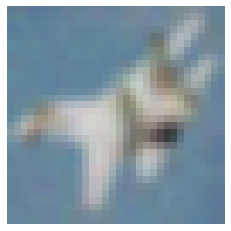

In [97]:
plt_show(gaussian_blur_fgsm[test_index])

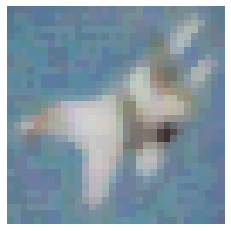

In [98]:
plt_show(median_blur_fgsm[test_index])

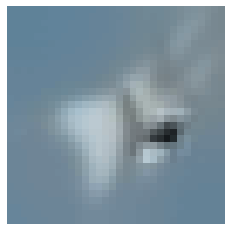

In [99]:
plt_show(nl_means_fgsm[test_index])

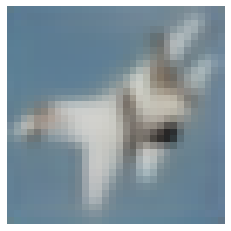

In [100]:
plt_show(dae_fgsm[test_index])

#### C&W

In [101]:
gaussian_blur_cw = dm_gaussian_blur.denoiser.predict(x_test_adv_cw_resnet)
median_blur_cw = dm_median_blur.denoiser.predict(x_test_adv_cw_resnet)
nl_means_cw = dm_nl_means.denoiser.predict(x_test_adv_cw_resnet)
dae_cw = dm_dae_resnet_model_resnet.denoiser.predict(x_test_adv_cw_resnet)

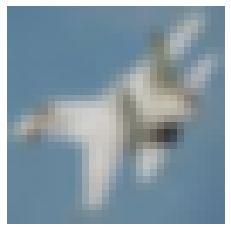

In [102]:
plt_show(gaussian_blur_cw[test_index])

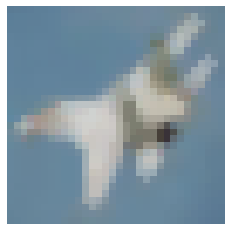

In [103]:
plt_show(median_blur_cw[test_index])

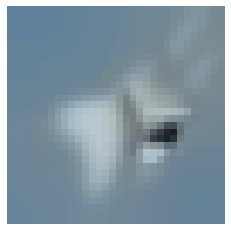

In [104]:
plt_show(nl_means_cw[test_index])

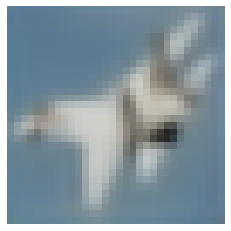

In [105]:
plt_show(dae_cw[test_index])

#### PGD

In [106]:
gaussian_blur_pgd = dm_gaussian_blur.denoiser.predict(x_test_adv_pgd_resnet)
median_blur_pgd = dm_median_blur.denoiser.predict(x_test_adv_pgd_resnet)
nl_means_pgd = dm_nl_means.denoiser.predict(x_test_adv_pgd_resnet)
dae_pgd = dm_dae_resnet_model_resnet.denoiser.predict(x_test_adv_pgd_resnet)

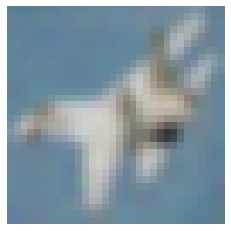

In [107]:
plt_show(gaussian_blur_pgd[test_index])

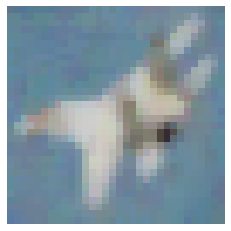

In [108]:
plt_show(median_blur_pgd[test_index])

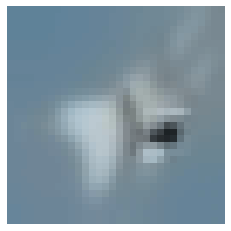

In [109]:
plt_show(nl_means_pgd[test_index])

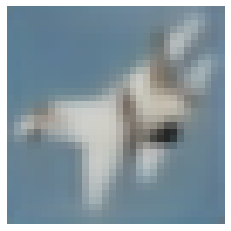

In [110]:
plt_show(dae_pgd[test_index])